<a href="https://colab.research.google.com/github/wint3rx3/flowers_classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import mysql.connector
from mysql.connector import Error

In [ ]:
class MySQLLogger(tf.keras.callbacks.Callback):
    def __init__(self, host, user, password, database, table_name):
        super(MySQLLogger, self).__init__()
        self.host = host
        self.user = user
        self.password = password
        self.database = database
        self.table_name = table_name
        self.conn = None
        self.cursor = None

    def on_train_begin(self, logs=None):
        try:
            self.conn = mysql.connector.connect(
                host=self.host,
                user=self.user,
                password=self.password,
                database=self.database
            )
            self.cursor = self.conn.cursor()
            # 테이블이 없으면 생성
            create_table_query = f"""
            CREATE TABLE IF NOT EXISTS {self.table_name} (
                epoch INT PRIMARY KEY,
                loss FLOAT,
                accuracy FLOAT,
                val_loss FLOAT,
                val_accuracy FLOAT
            )
            """
            self.cursor.execute(create_table_query)
            self.conn.commit()
            print("MySQL 연결 및 테이블 준비 완료")
        except Error as e:
            print("MySQL 연결 오류:", e)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        accuracy = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')

        insert_query = f"""
        INSERT INTO {self.table_name} (epoch, loss, accuracy, val_loss, val_accuracy)
        VALUES (%s, %s, %s, %s, %s)
        """
        data = (epoch + 1, loss, accuracy, val_loss, val_accuracy)
        try:
            self.cursor.execute(insert_query, data)
            self.conn.commit()
            print(f"Epoch {epoch+1} 데이터 저장 완료")
        except Error as e:
            print("데이터 저장 오류:", e)

    def on_train_end(self, logs=None):
        if self.cursor:
            self.cursor.close()
        if self.conn:
            self.conn.close()
        print("MySQL 연결 종료")

1. 데이터 다운로드 및 압축 해제

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d imsparsh/flowers-dataset

zip_path = "flowers-dataset.zip"
extract_path = "./flowers-dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

TRAIN_DIR = '/content/flowers-dataset/train'
TEST_DIR  = '/content/flowers-dataset/test'

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0


2. 클래스 정보 및 클래스 불균형 확인

In [4]:
classes = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(classes)
print("Classes:", classes)

# 각 클래스별 이미지 수 확인
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]
print("Class Counts:", dict(zip(classes, class_counts)))
total_samples = sum(class_counts)

# Keras 공식 문서 제안 방식에 따른 class_weight 계산
class_weight = {i: total_samples / (NUM_CLASSES * count) for i, count in enumerate(class_counts)}
print("Class Weight:", class_weight)

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class Counts: {'daisy': 501, 'dandelion': 646, 'rose': 497, 'sunflower': 495, 'tulip': 607}
Class Weight: {0: 1.0962075848303394, 1: 0.8501547987616099, 2: 1.105030181086519, 3: 1.1094949494949495, 4: 0.9047775947281713}


3. 데이터 증강 및 ImageDataGenerator 설정

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
VAL_SPLIT = 0.2

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # one-hot 인코딩 사용
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


4. 데이터 라벨 분포 시각화

===== Label Distribution (Train) =====
Class 0: 401 images
Class 1: 517 images
Class 2: 398 images
Class 3: 396 images
Class 4: 486 images

===== Label Distribution (Validation) =====
Class 0: 100 images
Class 1: 129 images
Class 2: 99 images
Class 3: 99 images
Class 4: 121 images


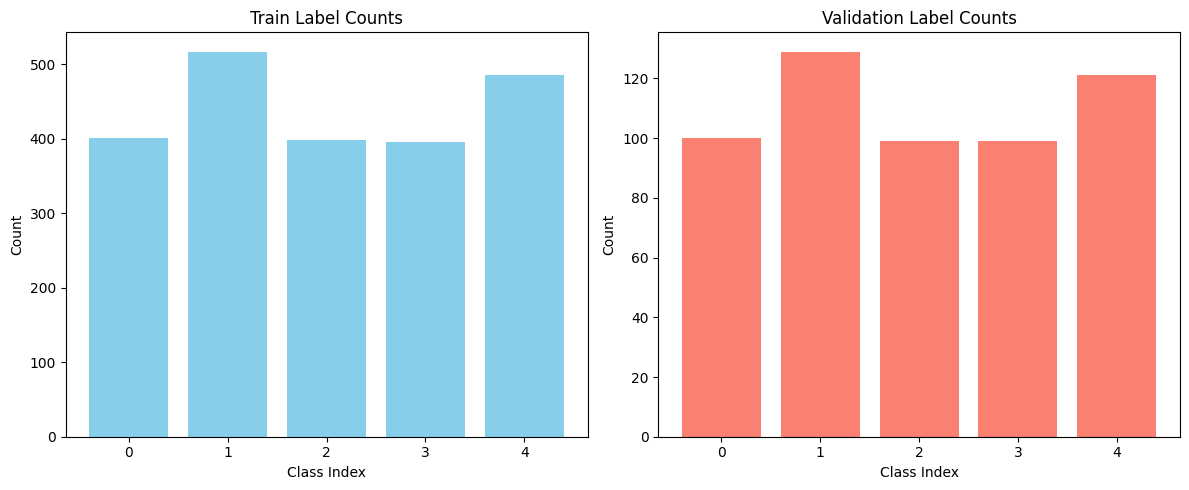

In [9]:
# Generator를 통해 실제 라벨 분포 수집
train_labels = []
validation_labels = []

train_generator.reset()
for i in range(len(train_generator)):
    _, y = next(train_generator)
    train_labels.extend(np.argmax(y, axis=1))

validation_generator.reset()
for i in range(len(validation_generator)):
    _, y = next(validation_generator)
    validation_labels.extend(np.argmax(y, axis=1))

train_label_counts = Counter(train_labels)
val_label_counts = Counter(validation_labels)

print("===== Label Distribution (Train) =====")
for k, v in sorted(train_label_counts.items()):
    print(f"Class {k}: {v} images")
print("\n===== Label Distribution (Validation) =====")
for k, v in sorted(val_label_counts.items()):
    print(f"Class {k}: {v} images")

# 간단한 바 차트 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(NUM_CLASSES), [train_label_counts[i] for i in range(NUM_CLASSES)], color='skyblue')
plt.title("Train Label Counts")
plt.xlabel("Class Index")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.bar(range(NUM_CLASSES), [val_label_counts[i] for i in range(NUM_CLASSES)], color='salmon')
plt.title("Validation Label Counts")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

5. 모델 구성: ResNet50 기반 (GlobalAveragePooling2D 사용)

In [10]:
# ResNet50 베이스 로드 (ImageNet weight) 및 전체 동결
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
resnet_base.trainable = False

model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

6. Phase 1 학습: 베이스 전체 동결 상태에서 학습

In [11]:
PHASE1_EPOCHS = 5
INITIAL_LR = 1e-3

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# MySQLLogger 콜백 인스턴스 생성 (DB 접속 정보 수정 필요)
mysql_logger = MySQLLogger(
    host='localhost',
    user='your_username',
    password='your_password',
    database='your_database',
    table_name='training_metrics'
)

history_phase1 = model.fit(
    train_generator,
    epochs=PHASE1_EPOCHS,
    validation_data=validation_generator,
    callbacks=[mysql_logger],
  class_weight=class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 650ms/step - accuracy: 0.2583 - loss: 1.6332 - val_accuracy: 0.3193 - val_loss: 1.5797
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 446ms/step - accuracy: 0.3420 - loss: 1.5175 - val_accuracy: 0.3942 - val_loss: 1.4680
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 448ms/step - accuracy: 0.3459 - loss: 1.5012 - val_accuracy: 0.3850 - val_loss: 1.4634
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 446ms/step - accuracy: 0.3623 - loss: 1.4861 - val_accuracy: 0.3923 - val_loss: 1.4515
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 448ms/step - accuracy: 0.4179 - loss: 1.4383 - val_accuracy: 0.3595 - val_loss: 1.4907


7. Phase 2 학습: 일부 레이어 Unfreeze 및 학습률 감소

In [12]:
for layer in resnet_base.layers[-5:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Phase 2 전용 MySQLLogger 콜백 인스턴스 생성 (테이블명은 상황에 맞게 변경 가능)
mysql_logger_phase2 = MySQLLogger(
    host='localhost',
    user='your_username',
    password='your_password',
    database='your_database',
    table_name='training_metrics_phase2'
)

history_phase2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, mysql_logger_phase2]
)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 55s 603ms/step - accuracy: 0.3551 - loss: 1.8590 - val_accuracy: 0.3248 - val_loss: 1.6501 - learning_rate: 1.0000e-04
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 448ms/step - accuracy: 0.4813 - loss: 1.3072 - val_accuracy: 0.3449 - val_loss: 1.6445 - learning_rate: 1.0000e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 449ms/step - accuracy: 0.5021 - loss: 1.2743 - val_accuracy: 0.3887 - val_loss: 1.5397 - learning_rate: 1.0000e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 448ms/step - accuracy: 0.5312 - loss: 1.1880 - val_accuracy: 0.3777 - val_loss: 1.5128 - learning_rate: 1.0000e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 450ms/step - accuracy: 0.5354 - loss: 1.2093 - val_accuracy: 0.4161 - val_loss: 1.4174 - learning_rate: 1.0000e-04
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.5452 - loss: 1.1558 - val_accuracy: 0.3996 - val_loss: 1.6277 - learning_rate: 1.0000e-04
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 446ms/step - acc

8. 전체 학습 결과 병합 및 시각화

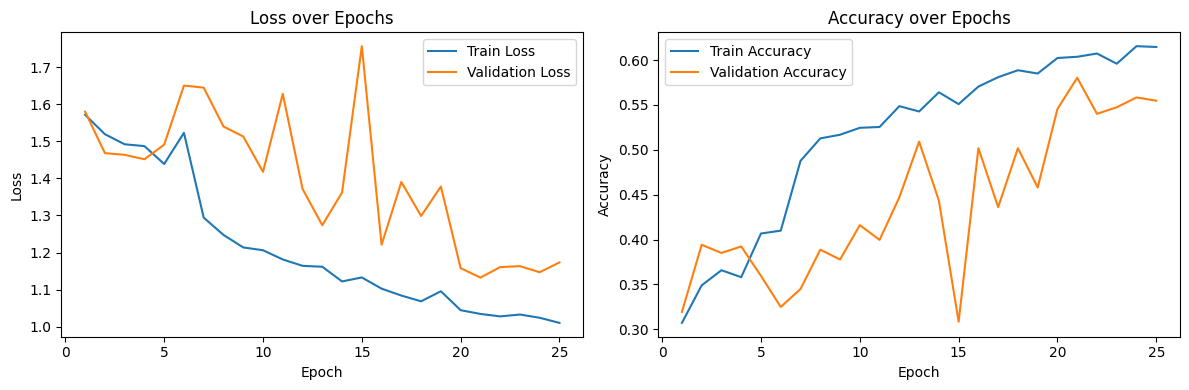

In [13]:
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss_values = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss_values = history_phase1.history['val_loss'] + history_phase2.history['val_loss']
epochs_total = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_total, loss_values, label='Train Loss')
plt.plot(epochs_total, val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_total, acc, label='Train Accuracy')
plt.plot(epochs_total, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

9. 최종 모델 평가

In [14]:
final_loss, final_accuracy = model.evaluate(validation_generator)
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.5656 - loss: 1.0814
Final Validation Loss: 1.1435
Final Validation Accuracy: 0.5474
